# Ex 2 - Transfer learning

###### Student 1: Daniel Ribeiro Cabral
###### Student 2: Ruben Terceiro


In [19]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score

## Load the Dataset and visualize it

In [20]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

In [21]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [22]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


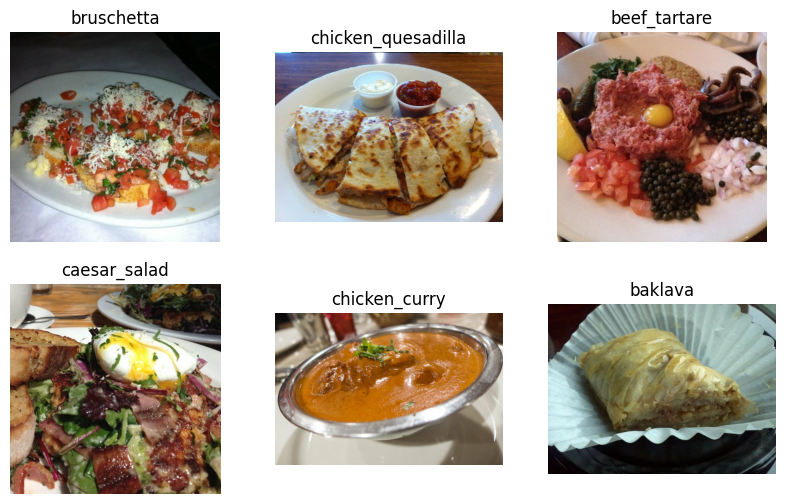

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [24]:
# TODO Resize the images in the training, validation and test set
def resize_images(image, label):
    return tf.image.resize(image, [160, 160]), label

train_ds = train_ds.map(resize_images)
validation_ds = validation_ds.map(resize_images)
test_ds = test_ds.map(resize_images)

In [25]:
# Normalize the images
def normalize_images(image, label):
    return image / 255.0, label

train_ds = train_ds.map(normalize_images)
validation_ds = validation_ds.map(normalize_images)
test_ds = test_ds.map(normalize_images)

In [17]:
5+5

10

In [26]:
# One hot encode the labels
def encode_labels(image, label):
    return image, tf.one_hot(label, depth=N_CLASSES)

train_ds = train_ds.map(encode_labels)
validation_ds = validation_ds.map(encode_labels)
test_ds = test_ds.map(encode_labels)

In [31]:
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
validation_ds = validation_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [32]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>

## Data-Augmentation

In [ ]:
# Optional define/implements data-augmentation

## Training
### Step 1: Only train the head of the network

In [33]:
%%time
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models.
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours.
# A model like mobilenet is more than enough for the exercise.

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(160, 160, 3))


# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(160, 160, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(N_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenet_1.00_160 (Functi  (None, 5, 5, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                20500     
                                                                 
Total params: 3249364 (12.40 MB)
Trainable params: 20500 (8

In [34]:
print(train_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>


In [35]:
%%time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Optional: Define and use callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

step1_history = model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=callbacks
)

Epoch 1/10
469/469 [==============================] - 102s 213ms/step - loss: 1.8552 - accuracy: 0.4524 - val_loss: 1.2001 - val_accuracy: 0.6229
Epoch 2/10
469/469 [==============================] - 106s 226ms/step - loss: 1.2759 - accuracy: 0.6107 - val_loss: 1.1057 - val_accuracy: 0.6551
Epoch 3/10
469/469 [==============================] - 99s 211ms/step - loss: 1.1339 - accuracy: 0.6535 - val_loss: 1.0489 - val_accuracy: 0.6667
Epoch 4/10
469/469 [==============================] - 99s 211ms/step - loss: 1.0490 - accuracy: 0.6793 - val_loss: 1.0163 - val_accuracy: 0.6814
Epoch 5/10
469/469 [==============================] - 99s 210ms/step - loss: 1.0165 - accuracy: 0.6883 - val_loss: 1.0203 - val_accuracy: 0.6814
Epoch 6/10
469/469 [==============================] - 99s 211ms/step - loss: 0.9879 - accuracy: 0.6961 - val_loss: 1.0257 - val_accuracy: 0.6790
Epoch 7/10
469/469 [==============================] - 98s 210ms/step - loss: 0.9635 - accuracy: 0.6989 - val_loss: 1.0264 - val_

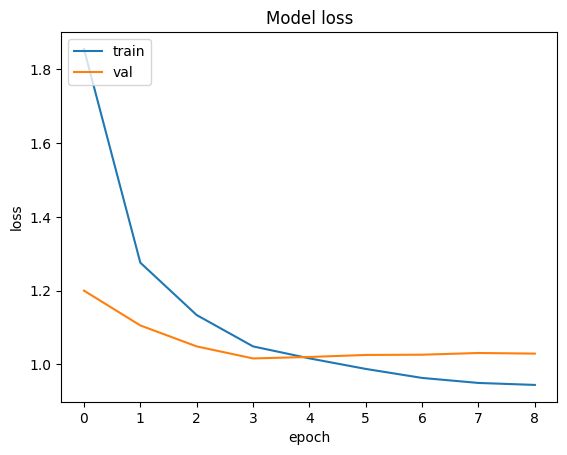

In [36]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [37]:
%%time


base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

step2_history = model.fit(
    train_ds,
    epochs=5,
    validation_data=validation_ds
)


Epoch 1/5
469/469 [==============================] - 124s 232ms/step - loss: 0.8873 - accuracy: 0.7235 - val_loss: 0.9690 - val_accuracy: 0.7017
Epoch 2/5
469/469 [==============================] - 116s 246ms/step - loss: 0.7861 - accuracy: 0.7497 - val_loss: 0.9418 - val_accuracy: 0.7068
Epoch 3/5
469/469 [==============================] - 109s 232ms/step - loss: 0.7064 - accuracy: 0.7751 - val_loss: 0.9335 - val_accuracy: 0.7168
Epoch 4/5
469/469 [==============================] - 108s 230ms/step - loss: 0.6405 - accuracy: 0.7945 - val_loss: 0.9142 - val_accuracy: 0.7235
Epoch 5/5
469/469 [==============================] - 116s 247ms/step - loss: 0.5834 - accuracy: 0.8175 - val_loss: 0.9084 - val_accuracy: 0.7267
CPU times: user 15min 36s, sys: 32 s, total: 16min 8s
Wall time: 11min 28s


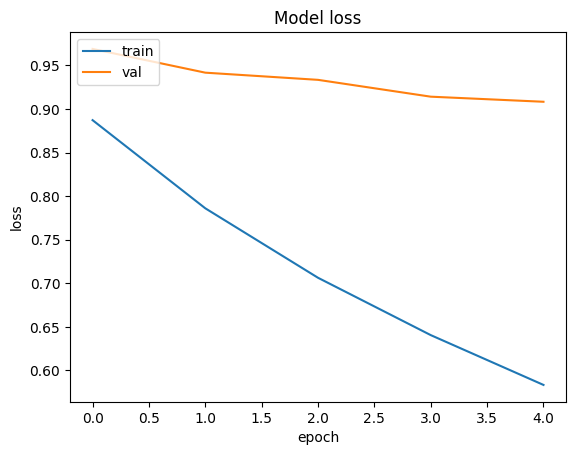

In [38]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [39]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

78/78 [==============================] - 16s 196ms/step
CPU times: user 48.7 s, sys: 2.22 s, total: 50.9 s
Wall time: 36.8 s


In [40]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7292839903459373
CPU times: user 3.18 ms, sys: 0 ns, total: 3.18 ms
Wall time: 3.04 ms


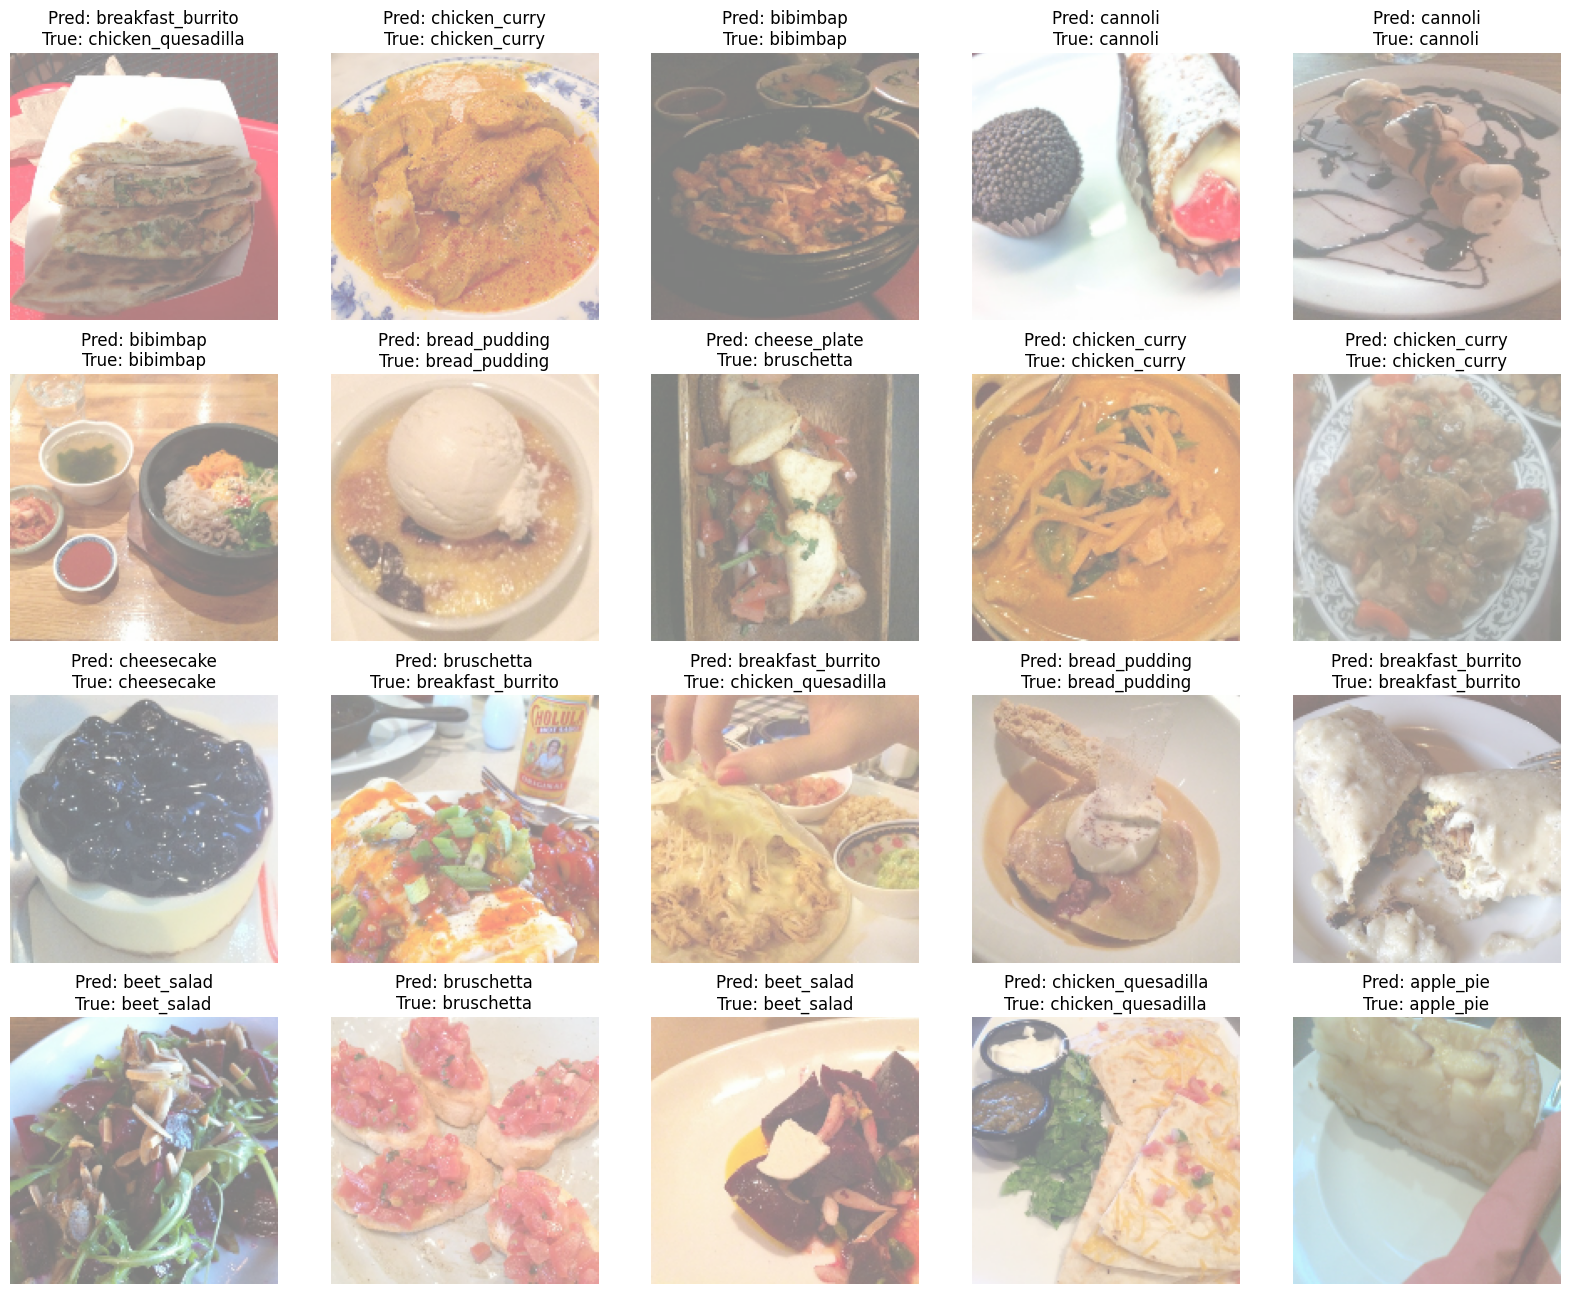

In [41]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")

    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)